[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/trim-filter-messages.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239435-lesson-4-trim-and-filter-messages)

# Filtering and trimming messages

## Review

Now, we have a deeper understanding of a few things: 

* How to customize the graph state schema
* How to define custom state reducers
* How to use multiple graph state schemas

## Goals

Now, we can start using these concepts with models in LangGraph!
 
In the next few sessions, we'll build towards a chatbot that has long-term memory.

Because our chatbot will use messages, let's first talk a bit more about advanced ways to work with messages in graph state.

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_openai

In [2]:
# Run this cell and paste the API key in the prompt
import os
import configparser
# Create a ConfigParser object
config = configparser.ConfigParser()

# Read the configuration file
config.read('../../.config.ini')
os.environ['GOOGLE_API_KEY'] = config.get('GoogleGeminiAPI', 'Google_Gemini_API_KEY')

os.environ['LANGCHAIN_TRACING_V2'] = config.get('LangChain', 'LANGCHAIN_TRACING_V2')
os.environ['LANGCHAIN_ENDPOINT'] = config.get('LangChain', 'LANGCHAIN_ENDPOINT')
os.environ['LANGCHAIN_API_KEY'] = config.get('LangChain', 'LANGCHAIN_API_KEY')
os.environ['USER_AGENT'] = config.get('LangChain', 'USER_AGENT')

os.environ['OPENAI_API_KEY'] = config.get('OpenAI', 'OPENAI_API_KEY')
os.environ['TAVILY_API_KEY'] = config.get('Tavily_Search_API', 'Tavily_API_KEY')
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"


We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

We'll log to a project, `langchain-academy`. 

## Messages as state

First, let's define some messages.

In [3]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
messages = [AIMessage(f"So you said you were researching ocean mammals?", name="Bot")]
messages.append(HumanMessage(f"Yes, I know about whales. But what others should I learn about?", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?


Recall we can pass them to a chat model.

In [4]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")
llm.invoke(messages)

AIMessage(content='In addition to whales, there are several other fascinating ocean mammals you might want to explore:\n\n1. **Dolphins**: Known for their intelligence and playful behavior, dolphins are found in oceans worldwide. They belong to the family Delphinidae and include species like the bottlenose dolphin and the orca (killer whale).\n\n2. **Porpoises**: Similar to dolphins, porpoises are smaller and have different physical characteristics, such as shorter beaks and spade-shaped teeth. They are less commonly seen than dolphins.\n\n3. **Seals**: These pinnipeds are divided into two families: the earless or true seals (Phocidae) and the eared seals, which include sea lions and fur seals (Otariidae).\n\n4. **Sea Lions and Fur Seals**: These are part of the Otariidae family and are known for their external ear flaps and ability to walk on land using their large flippers.\n\n5. **Walruses**: Recognizable by their long tusks and whiskers, walruses are large marine mammals that inhab

We can run our chat model in a simple graph with `MessagesState`.

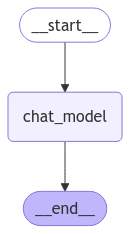

In [5]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

# Node
def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

In addition to whales, there are several other fascinating ocean mammals you might want to explore:

1. **Dolphins**: Known for their intelligence and playful behavior, dolphins are part of the cetacean family, which also includes whales and porpoises. Common species include the bottlenose dolphin and the orca, or killer whale.

2. **Porpoises**: Often confused with dolphins, porpoises are smaller and have different dental and facial structures. They are generally more shy and elusive.

3. **Seals**: These are part of the pinniped family, which also includes sea lions and walruses. Common species include the harb

## Reducer

A practical challenge when working with messages is managing long-running conversations. 

Long-running conversations result in high token usage and latency if we are not careful, because we pass a growing list of messages to the model.

We have a few ways to address this.

First, recall the trick we saw using `RemoveMessage` and the `add_messages` reducer.

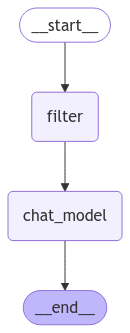

In [7]:
from langchain_core.messages import RemoveMessage

# Nodes
def filter_messages(state: MessagesState):
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState):    
    return {"messages": [llm.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
# Message list with a preamble
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

# Invoke
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

In addition to whales, there are several other fascinating ocean mammals that you might want to explore:

1. **Dolphins**: Known for their intelligence and playful behavior, dolphins are part of the cetacean family, which also includes whales and porpoises.

2. **Porpoises**: Similar to dolphins, porpoises are smaller and have different facial structures and teeth shape. They are less social than dolphins and often found in colder waters.

3. **Seals**: These pinnipeds are known for their sleek bodies and ability to live both on land and in water. There are many species, including the harbor seal and the elephant

## Filtering messages

If you don't need or want to modify the graph state, you can just filter the messages you pass to the chat model.

For example, just pass in a filtered list: `llm.invoke(messages[-1:])` to the model.

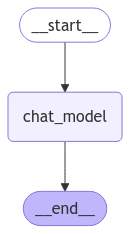

In [9]:
# Node
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Let's take our existing list of messages, append the above LLM response, and append a follow-up question.

In [10]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me more about Narwhals!", name="Lance"))

In [11]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

In addition to whales, there are several other fascinating ocean mammals that you might want to explore:

1. **Dolphins**: Known for their intelligence and playful behavior, dolphins are part of the cetacean family, which also includes whales and porpoises.

2. **Porpoises**: Similar to dolphins, porpoises are smaller and have different facial structures and teeth shape. They are less social than dolphins and often found i

In [12]:
# Invoke, using message filtering
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

In addition to whales, there are several other fascinating ocean mammals that you might want to explore:

1. **Dolphins**: Known for their intelligence and playful behavior, dolphins are part of the cetacean family, which also includes whales and porpoises.

2. **Porpoises**: Similar to dolphins, porpoises are smaller and have different facial structures and teeth shape. They are less social than dolphins and often found i

The state has all of the mesages.

But, let's look at the LangSmith trace to see that the model invocation only uses the last message:

https://smith.langchain.com/public/75aca3ce-ef19-4b92-94be-0178c7a660d9/r

## Trim messages

Another approach is to [trim messages](https://python.langchain.com/v0.2/docs/how_to/trim_messages/#getting-the-last-max_tokens-tokens), based upon a set number of tokens. 

This restricts the message history to a specified number of tokens.

While filtering only returns a post-hoc subset of the messages between agents, trimming restricts the number of tokens that a chat model can use to respond.

See the `trim_messages` below.

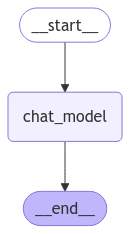

In [13]:
from langchain_core.messages import trim_messages

# Node
def chat_model_node(state: MessagesState):
    messages = trim_messages(
            state["messages"],
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=False,
        )
    return {"messages": [llm.invoke(messages)]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me where Orcas live!", name="Lance"))

In [15]:
# Example of trimming messages
trim_messages(
            messages,
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=False
        )

[HumanMessage(content='Tell me where Orcas live!', additional_kwargs={}, response_metadata={}, name='Lance')]

In [16]:
# Invoke, using message trimming in the chat_model_node 
messages_out_trim = graph.invoke({'messages': messages})

Let's look at the LangSmith trace to see the model invocation:

https://smith.langchain.com/public/b153f7e9-f1a5-4d60-8074-f0d7ab5b42ef/r